In [2]:
import csv
import os
import numpy as np
import cv2
import keras

from keras.models import load_model
from keras.models import model_from_json
import h5py
from keras import __version__ as keras_version

from time import sleep
from tqdm import tqdm

test_seq = ['01' ,'02', '03', '04', '05', '06', '07', '08', '09', '00', '10']

data_path = "/media/Data/kitti_dataset/dataset/sequences/"
test_set = []

for i in range(len(test_seq)):
    with open(data_path + str(test_seq[i]) + "/speed.txt", 'r') as h:
        lines = h.readlines()

    dataset = []
    images_path = sorted(os.listdir(data_path + str(test_seq[i]) + "/image_2"))

    for j in range(len(lines)):
        speed_val = float(lines[j].strip())
        dataset.append({"image": data_path+str(test_seq[i])+"/image_2/"+images_path[j+1], "speed": speed_val/15.0 - 1.0})
    
    test_set.append(dataset)
    print(len(dataset))
    
print(test_set[0][6])

920
1060
3280
630
1900
1730
490
1800
4980
830
2720
{'speed': -1.0, 'image': '/media/Data/kitti_dataset/dataset/sequences/11/image_2/000007.png'}


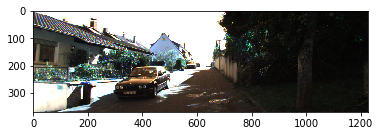

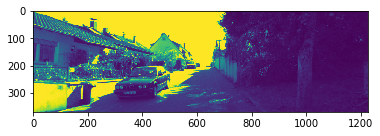

(370, 1226)


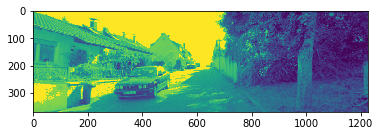

In [3]:
import matplotlib.pyplot as plt

img = cv2.imread(test_set[0][44]['image'])[:, :]
plt.imshow(img)
plt.show()

img_b = cv2.imread(test_set[0][44]['image'], 0)
plt.imshow(img_b)
plt.show()

equ = cv2.equalizeHist(img_b)
print(equ.shape)
#res = np.hstack((img_b, sat, equ))
plt.imshow(equ)
plt.show()

In [4]:
seq_images = []
seq_len = 5

def img_for_model(data):
    img = cv2.imread(data["image"], 0)[:370, :1226]
    img = cv2.equalizeHist(img)
    img = np.asarray(img).reshape(370, 1226, 1)
    return img

def predict_speed(model, data):
    global seq_images, seq_len

    pred_speed = 0.0
    gt_speed = data["speed"]

    image_array = img_for_model(data)

    if len(seq_images) < seq_len:
        seq_images.append(image_array)

        transformed_image_array = np.array(seq_images)
        transformed_image_array = transformed_image_array[None, :, :, :, :]

        pred_speed = float(model.predict(transformed_image_array, batch_size=1)[-1][0])*15 + 15


    else:
        seq_images.pop(0)
        seq_images.append(image_array)

        transformed_image_array = np.array(seq_images)
        transformed_image_array = transformed_image_array[None, :, :, :, :]

        pred_speed = float(model.predict(transformed_image_array, batch_size=1)[-1][0])*15 + 15

    return pred_speed, gt_speed

In [5]:
model_path = "../data/weights/kitti_speed/model.json"
with open(model_path, 'r') as jfile:
    model = model_from_json(jfile.read())

model.compile("adam", "mse")
weights_file = model_path.replace('json', 'h5')
model.load_weights(weights_file)

In [6]:
times_path = "/media/Data/kitti_dataset/dataset/sequences/"

for j in range(len(test_seq)):
    times_inst = times_path + test_seq[j] + "/speed_nn.txt";

    with open(times_inst, 'w') as handle:
        for i in tqdm(range(len(test_set[j])), total=len(test_set[j])):
            pred_speed, gt_speed = predict_speed(model, test_set[j][i])
            handle.write(str(pred_speed) + "\n")

100%|██████████| 2720/2720 [03:21<00:00, 13.71it/s]


In [ ]:
# To create video


# font = cv2.FONT_HERSHEY_SIMPLEX
# fourcc = cv2.VideoWriter_fourcc(*'MJPG')

# for j in range(len(test_seq)):
#     out = cv2.VideoWriter('kitti_nn_' + test_seq[j] + '.avi',fourcc, 20.0, (1241, 376))

#     for i in tqdm(range(len(test_set[j])), total=len(test_set[j])):
#         pred_speed, gt_speed = predict_speed(model, test_set[j][i])
#         pred_speed = round(pred_speed, 2)
#         gt_speed = round(gt_speed, 2)
#         image = cv2.imread(test_set[j][i]["image"])
#         cv2.putText(image, str(pred_speed), (30,300), font, 0.5,(0,255,0),1,cv2.LINE_AA)
#         cv2.putText(image, str(gt_speed), (30,330), font, 0.5,(0,0,255),1,cv2.LINE_AA)
#         out.write(image)

#     out.release()
#cv2.destroyAllWindows()